# Feature Transformation - Linear and Non Linear

- When a dataset has many different features, it can be helpful to distill the variance across the features into a more descriptive subset of features. In this analysis, both linear and non-linear feature extraction have been used to find powerful features that effectivley describe each classification of the wine dataset from sklean.

### Import Required Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, Model
from keras.layers import Input, Dense
from tensorflow import keras
from keras.models import Sequential

from sklearn.decomposition import PCA
import plotly.express as px 

### Load Data

In [2]:
wine = pd.read_csv('wine_sklearn_data.csv') # data was obtianed via sklearn

# Visualize the dataframe
wine.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  Class  
0                          3.92   1065.0      0  
1                          3.40   1050.0      0  
2                          3.17   1185.0      0  
3                          3.45   1480.0      0  
4                          2.93    735.0      0

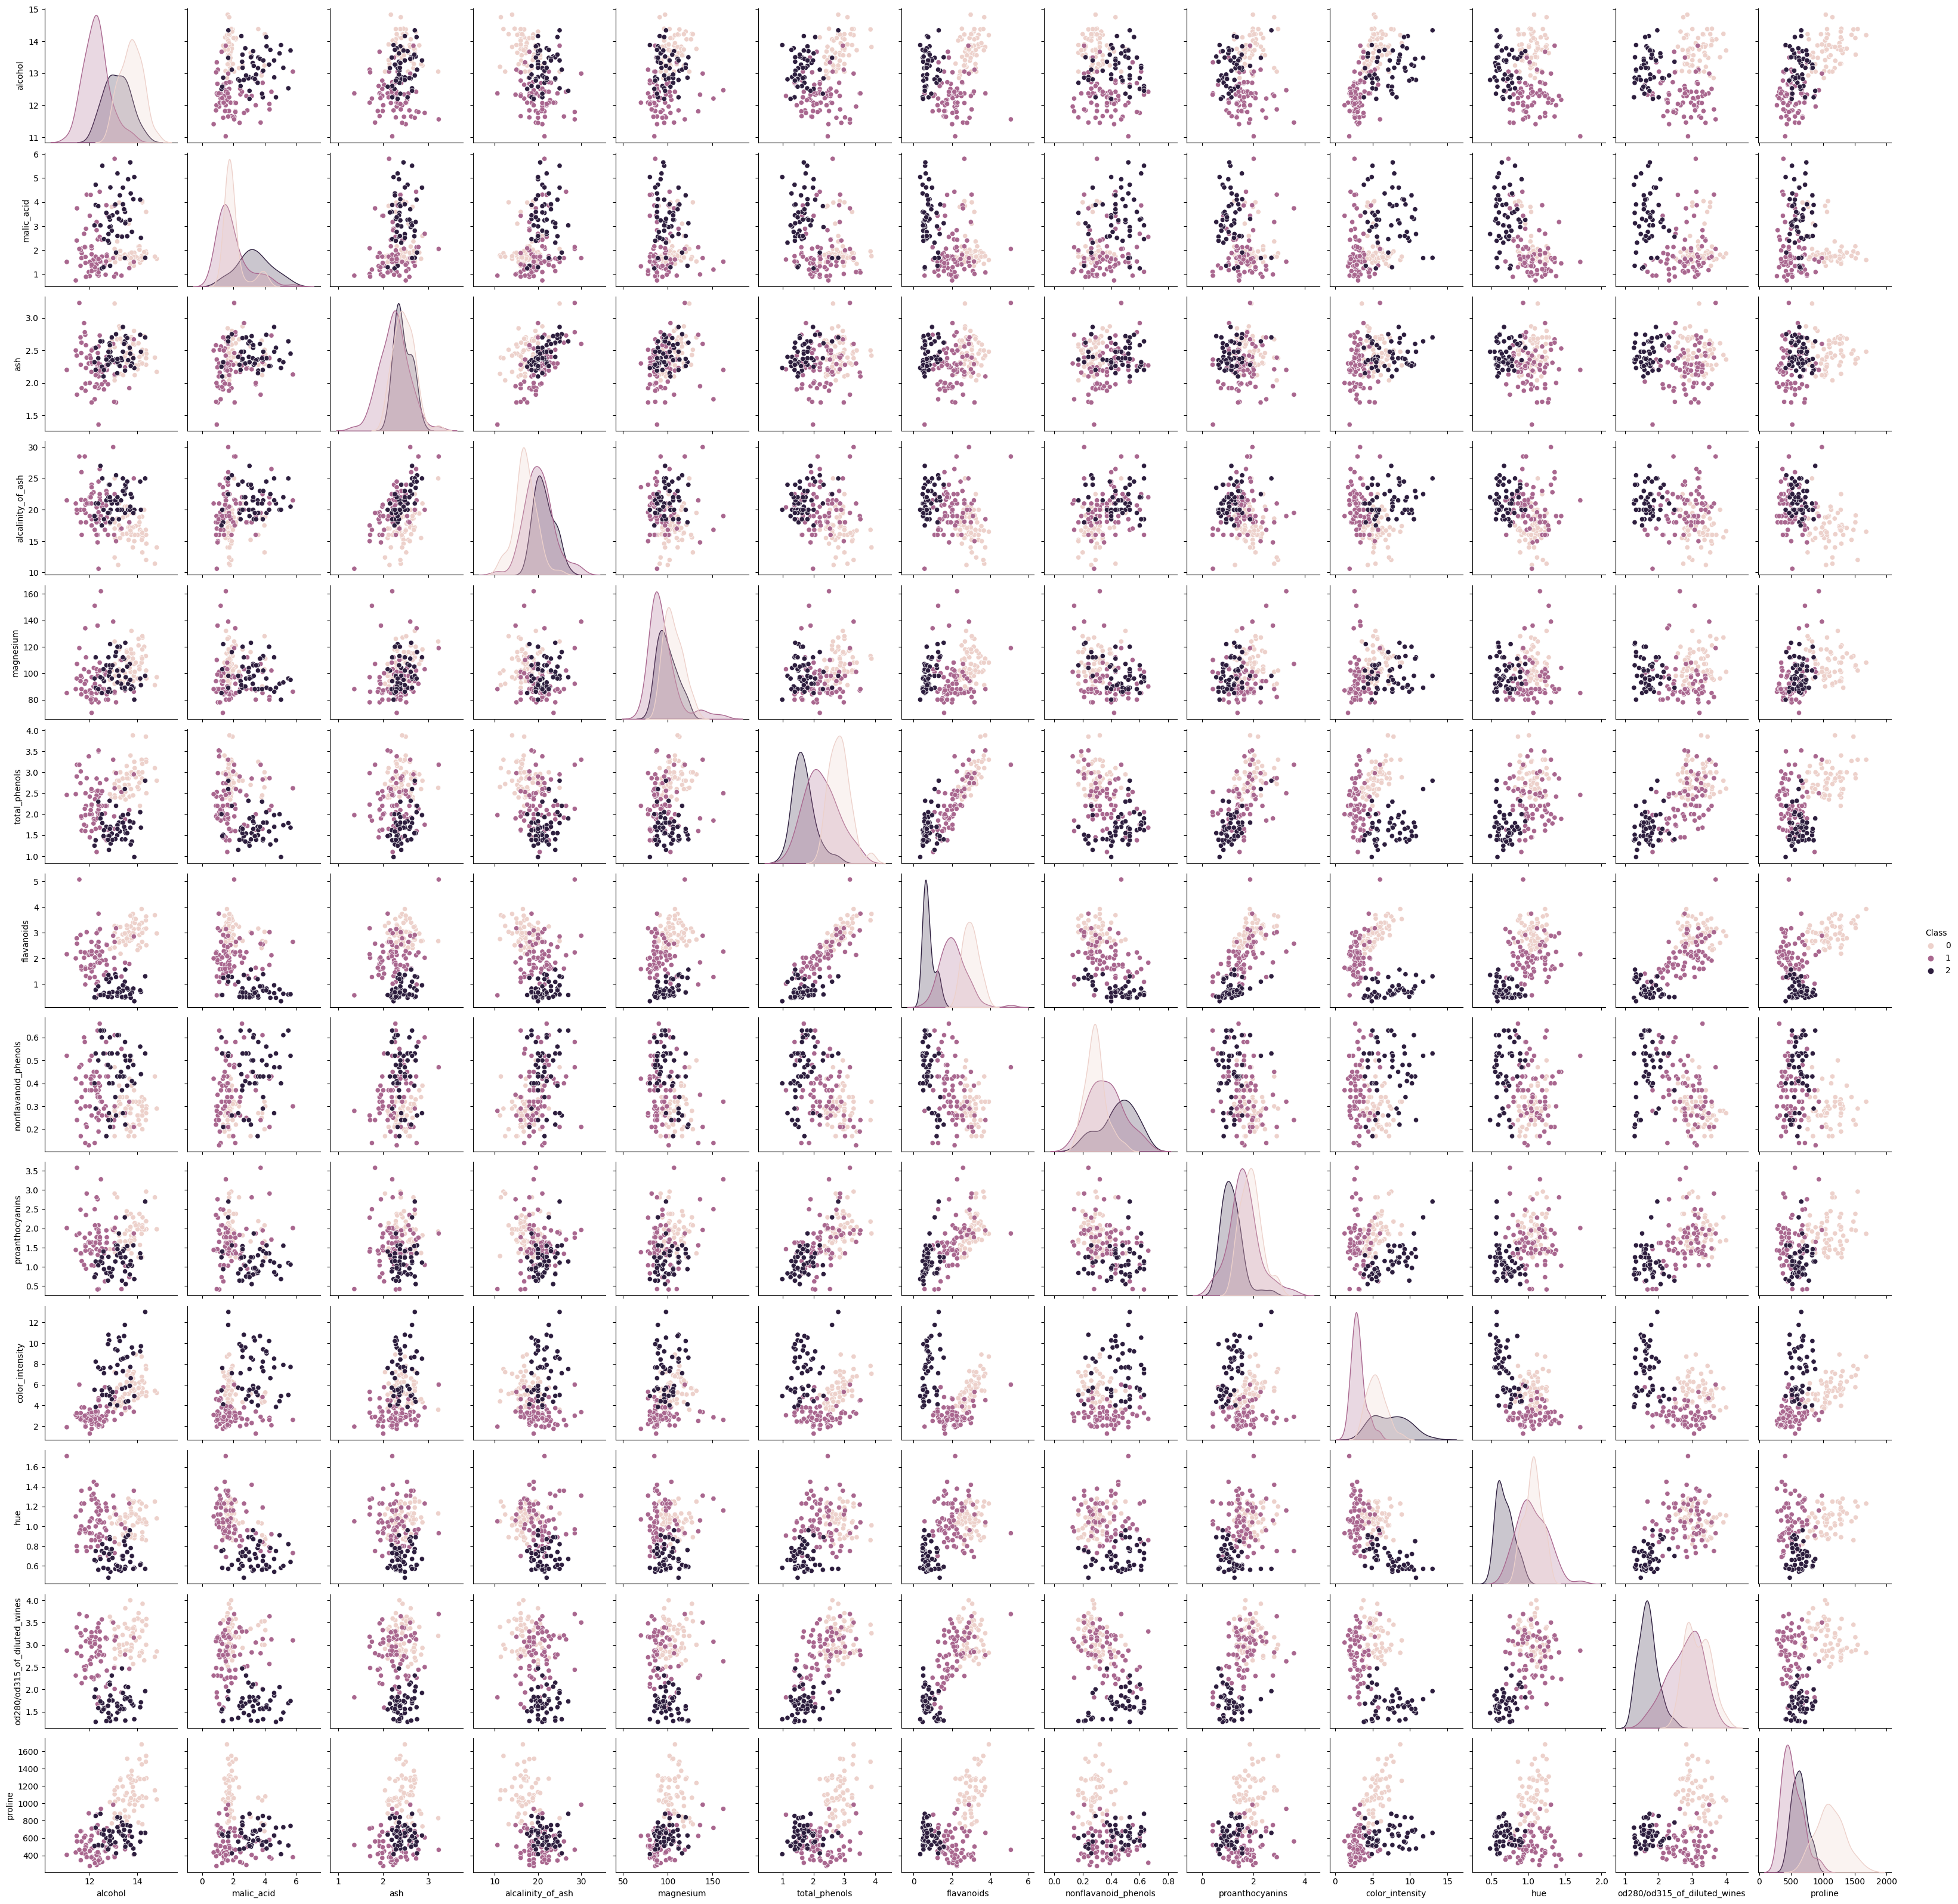

In [3]:
# Visualize the different classes across all of the pair wise feature combinations
sns.pairplot(data = wine, hue = 'Class')

In [4]:
# Standardize the features so the models do not allocate an unproportionate 
# weight to the features of larger magnitude.
features = wine.columns[:-1]
wine_norm = StandardScaler().fit_transform(wine[features])
wine_df = pd.DataFrame(wine_norm, columns = features)

wine_df['Class'] =wine['Class']

# Non-linear Tranformation - Autoencoder Methodology

In [5]:
# Encoder
original_features = len(features)

input_layer = Input(shape=(original_features,))
encoded = Dense(10, activation='relu')(input_layer)
encoded = Dense(7, activation='relu')(encoded)
encoded = Dense(5, activation='relu')(encoded)
encoder_output = Dense(2)(encoded)

encoder = models.Model(input_layer, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 10)                140       
                                                                 
 dense_1 (Dense)             (None, 7)                 77        
                                                                 
 dense_2 (Dense)             (None, 5)                 40        
                                                                 
 dense_3 (Dense)             (None, 2)                 12        
                                                                 
Total params: 269
Trainable params: 269
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Decoder
decoder_input = Input(shape=(2,))
decoder = Dense(2, activation='relu')(decoder_input)
decoder = Dense(5, activation = 'relu')(decoder)
decoder = Dense(7, activation = 'relu')(decoder)
decoder = Dense(10, activation = 'relu')(decoder)
decoder_output = Dense(original_features)(decoder)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 6         
                                                                 
 dense_5 (Dense)             (None, 5)                 15        
                                                                 
 dense_6 (Dense)             (None, 7)                 42        
                                                                 
 dense_7 (Dense)             (None, 10)                80        
                                                                 
 dense_8 (Dense)             (None, 13)                143       
                                                                 
Total params: 286
Trainable params: 286
Non-trainable param

In [7]:
# Autoencoder - Combine the Encoder and Decoder
autoencoder = models.Model(input_layer, decoder(encoder_output))
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 10)                140       
                                                                 
 dense_1 (Dense)             (None, 7)                 77        
                                                                 
 dense_2 (Dense)             (None, 5)                 40        
                                                                 
 dense_3 (Dense)             (None, 2)                 12        
                                                                 
 model_1 (Functional)        (None, 13)                286       
                                                                 
Total params: 555
Trainable params: 555
Non-trainable param

In [8]:
# Compile the autoencoder
# Sparse categorical cross entropy was also attempted as loss however mse appears to work better
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

In [9]:
# Fit the model
# Verbose can be set to visualize the model training process
autoencoder.fit(wine_df[features], wine_df['Class'], batch_size=30, epochs=1000, shuffle = True,
                verbose = 0)

In [10]:
# Use the embedding side of the trained auto-encoder to distill the features down to the output
embeddings = encoder.predict(wine_df[features])

6/6 [==============================] - 0s 2ms/step


In [11]:
# Save the calculated embeddings into the original dataframe as new features
embedding_1 = []
embedding_2 = []

for i in range(len(embeddings)):
    embedding_1.append(embeddings[i][0])
    embedding_2.append(embeddings[i][1])
    
wine_df['embedding_1'] = embedding_1
wine_df['embedding_2'] = embedding_2

In [12]:
# Review the dataframe
wine_df.head()

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
0  1.518613   -0.562250  0.232053          -1.169593   1.913905   
1  0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2  0.196879    0.021231  1.109334          -0.268738   0.088358   
3  1.691550   -0.346811  0.487926          -0.809251   0.930918   
4  0.295700    0.227694  1.840403           0.451946   1.281985   

   total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0       0.808997    1.034819             -0.659563         1.224884   
1       0.568648    0.733629             -0.820719        -0.544721   
2       0.808997    1.215533             -0.498407         2.135968   
3       2.491446    1.466525             -0.981875         1.032155   
4       0.808997    0.663351              0.226796         0.401404   

   color_intensity       hue  od280/od315_of_diluted_wines   proline  Class  \
0         0.251717  0.362177                      1.847920  1.013009      0   
1        -0.293321  0.406051                      1.113449  0.965242      0   
2         0.269020  0.318304                      0.788587  1.395148      0   
3         1.186068 -0.427544                      1.184071  2.334574      0   
4        -0.319276  0.362177                      0.449601 -0.037874      0   

   embedding_1  embedding_2  
0    -1.735704    -2.340741  
1    -1.464197    -2.022386  
2    -1.164541    -1.325254  
3    -2.398723    -3.140263  
4    -0.912690    -1.134540

<AxesSubplot: xlabel='embedding_1', ylabel='embedding_2'>

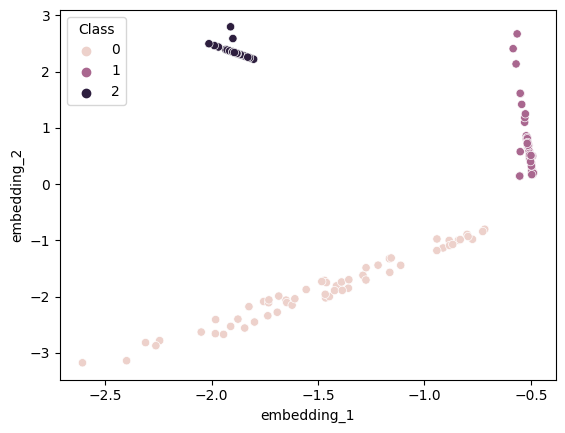

In [13]:
# Visulaize the different classes of wine across the two newly created features
# As seen below, clear separation has been created in the data across the wine classes
sns.scatterplot(data = wine_df, x = 'embedding_1', y = 'embedding_2', hue = 'Class')

# PCA Linear Dimentionality Reduction
- Linear transformation of the data which captures a majority of the variance across a subset of the transformed features

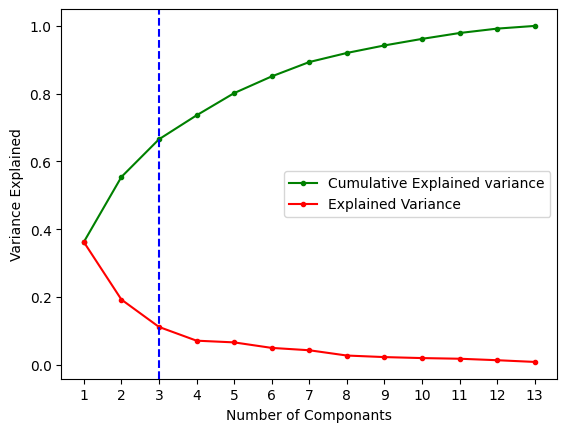

In [14]:
# Run multiple iterations of PCA to determine what the appropriate number of componants to use will be
# as determined by the cumulative explained variance as seen plotted below.

#PCA
pca = PCA().fit(wine_df[features])

#Explained Variance Ratio
exp_var = pca.explained_variance_ratio_

# Cumulative sum of variance explained
exp_var_cumsum = np.cumsum(exp_var)

plt.plot(range(1,len(features) + 1), exp_var_cumsum, 'g.-', label = 'Cumulative Explained variance')
plt.plot(range(1,len(features) + 1), exp_var, 'r.-', label = 'Explained Variance')
plt.legend()
plt.xlabel('Number of Componants')
plt.xticks(np.arange(1, len(features) + 1, step=1))
plt.ylabel('Variance Explained')
plt.axvline(3, linestyle = '--', color = 'blue')
plt.show()

In [15]:
# As it appears the rate of explained variance tappers off after the third pricipal componant
# and for plotting purposes it will be easier to visualize in three dimensions therefore
# three principal components will be used.
pca = PCA(n_components=3)
components = pca.fit_transform(wine_df)
components = pd.DataFrame(components, columns = ['PC_1', 'PC_2', 'PC_3'])

# Save the three new features into the original dataframe
wine_df['PC_1'], wine_df['PC_2'], wine_df['PC_3'] = components['PC_1'], components['PC_2'], components['PC_3']

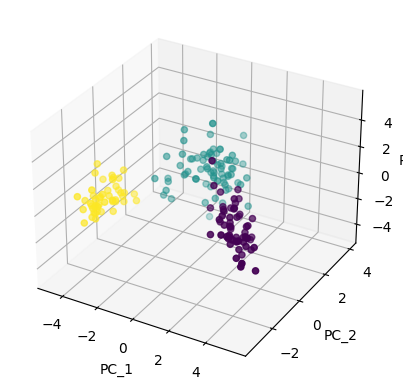

In [16]:
# Visulaize the different classes of wine across the three newly created features
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(wine_df['PC_1'], wine_df['PC_2'], wine_df['PC_3'], c = wine['Class']);

ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')
ax.set_zlabel('PC_3')

plt.show()